# Final Project

 ## Daniel Blessing

## Can we use historical data from professional league of legends games to try and predict the results of future contests?

## Load Data

In [20]:
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier # ensemble models we're trying out
from sklearn.model_selection    import train_test_split # train test split for CV
from sklearn.metrics            import accuracy_score, f1_score # two evalutaion metrics for binary classification
from sklearn.pipeline           import Pipeline # robust pipeline
from sklearn.impute             import *
from sklearn.preprocessing      import *
from sklearn.compose            import * # preprocessing importance
from sklearn.base               import BaseEstimator #for randomized CV
from sklearn.model_selection import RandomizedSearchCV


# data pocessing
import numpy as np
import pandas as pd


# load data from local else download it from github
filename = 'Dev.csv'
remote_location = 'https://raw.githubusercontent.com/Drblessing/predcting_LoL/master/Lol.csv'

try: 
  # Local version 
  df = pd.read_csv(filename,index_col = 0)
except FileNotFoundError or ParserError: 
  # Grab the remote file and save it    
  df = pd.read_csv(remote_location,index_col = 0)
  df.to_csv(filename)


# create X,y datasets and train_test split them
y = df['bResult']
df = df.drop(columns = ['bResult'])
X = df
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True,random_state = 42)

# Legacy Feature Engineering
'''pregame_data = Lol[['bResult','blueTopChamp','blueJungleChamp','blueMiddleChamp','blueADCChamp','blueSupportChamp',
                   'blueBans','redTopChamp','redJungleChamp','redMiddleChamp','redADCChamp','redSupportChamp','redBans']]

# process list of bans into individual columns
pregame_data_b = pregame_data.assign(names=pregame_data.blueBans.str.split(",")) 

pregame_data_r = pregame_data.assign(names=pregame_data.redBans.str.split(",")) 

blue_bans = pregame_data_b.names.apply(pd.Series)

red_bans = pregame_data_r.names.apply(pd.Series)

blue_names = {0: "b1", 1: "b2",2:"b3",3:"b4",4:"b5"}
red_names = {0:"r1",1:"r2",2:"r3",3:"r4",4:"r5"}

blue_bans = blue_bans.rename(columns=blue_names)

red_bans = red_bans.rename(columns=red_names)

pregame_data = pd.concat([pregame_data, blue_bans,red_bans], axis=1)

# drop legacy columns
pregame_data = pregame_data.drop(columns = ['blueBans','redBans'])

# define y and drop it 
y = pregame_data['bResult']
pregame_data = pregame_data.drop(columns = ['bResult'])

# fix blue bans strings
pregame_data.b1 = pregame_data.b1.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.b2 = pregame_data.b2.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.b3 = pregame_data.b3.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.b4 = pregame_data.b4.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.b5 = pregame_data.b5.str.replace('[','').str.replace(']','').str.replace("'",'')

# fix red bans strings
pregame_data.r1 = pregame_data.r1.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.r2 = pregame_data.r2.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.r3 = pregame_data.r3.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.r4 = pregame_data.r4.str.replace('[','').str.replace(']','').str.replace("'",'')
pregame_data.r5 = pregame_data.r5.str.replace('[','').str.replace(']','').str.replace("'",'')''';

## Visuatlizations

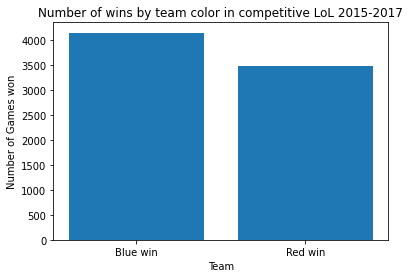

In [17]:
# visualizations 
import matplotlib.pyplot as plt
from collections import Counter

x = ['Blue win','Red win']

heights = [0,0]
heights[0] = sum(y)
heights[1] = len(y) - sum(y)

plt.bar(x,heights);
plt.ylabel('Number of Games won');
plt.xlabel('Team');
plt.title('Number of wins by team color in competitive LoL 2015-2017');

In [51]:
# check general accuracy of naive model
bw = sum(y)/len(y)
print(f'Percentage of games won by blue team: {bw*100:.2f} %')

Percentage of games won by blue team: 54.41 %


Text(0.5, 1.0, 'Distribution of ADC champs for competitive Lol 2015-2017')

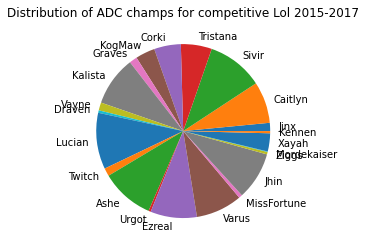

In [10]:
# load champs
champs = Counter(X['blueADCChamp'])
l = champs.keys()
v = champs.values()

# get rid of one off champs
l = [l_ for l_ in l if champs[l_] > 1]
v = [v_ for v_ in v if v_ > 1]
plt.pie(v,labels=l);

plt.title('Distribution of ADC champs for competitive Lol 2015-2017')

## Model Building

In [22]:
# define categorical variables, all of our data 
categorical_columns = (X.dtypes == object)

# impute missing values and hot encode categories
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value='Unknown', add_indicator=True)),
                    ('ohe', OneHotEncoder(handle_unknown='ignore'))])


# process categorical variables
preprocessing = ColumnTransformer([('categorical', cat_pipe, categorical_columns)], remainder='passthrough')

# Helper class for RandomizedSearchCV
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

    
# create pipeline
pipe = Pipeline(steps = [('preprocessing', preprocessing), 
                         ('clf', DummyEstimator())])

search_space = [
            {'clf': [ExtraTreesClassifier(n_jobs=-1,random_state=42)], 
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__min_samples_leaf': np.linspace(1, 30, 5, dtype=int),
                        'clf__bootstrap': [True, False],
                        'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
                        'clf__n_estimators': np.linspace(50, 500, 8, dtype=int)},
            {'clf': [RandomForestClassifier(n_jobs=-1,random_state=42)], 
             'clf__criterion': ['gini', 'entropy'],
             'clf__min_samples_leaf': np.linspace(1, 10, 4, dtype=int),
             'clf__bootstrap': [True, False],
             'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
             'clf__n_estimators': np.linspace(50, 300, 5, dtype=int)}]
                          

gs = RandomizedSearchCV(pipe, 
                        search_space, 
                        scoring='accuracy',  # accuracy for game prediction
                        n_iter=30,
                        cv=5,
                        n_jobs=-1)
    
gs.fit(X, y);

In [23]:
gs.best_score_, gs.best_params_

(0.5513123359580052,
 {'clf__n_estimators': 114,
  'clf__min_samples_leaf': 15,
  'clf__criterion': 'gini',
  'clf__class_weight': None,
  'clf__bootstrap': True,
  'clf': ExtraTreesClassifier(bootstrap=True, min_samples_leaf=15, n_estimators=114,
                       n_jobs=-1)})

In [ ]:
# Results:
'''
(0.5513123359580052,
 {'clf__n_estimators': 114,
  'clf__min_samples_leaf': 15,
  'clf__criterion': 'gini',
  'clf__class_weight': None,
  'clf__bootstrap': True,
  'clf': ExtraTreesClassifier(bootstrap=True, min_samples_leaf=15, n_estimators=114,
                       n_jobs=-1)})'''



## Evaluation Metric

In [44]:
pipe = Pipeline([('preprocessing', preprocessing), 
                ('clf', ExtraTreesClassifier(
                bootstrap = True,
                min_samples_leaf = 15,
                n_estimators = 114,
                n_jobs = -1,
                criterion = 'gini',
                class_weight = None,
                random_state=42))])

pipe.fit(X_train,y_train);

y_pred = pipe.predict(X_val)
accuracy = accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)


print(f"accuracy: {accuracy:,.6f}")
print(f"f1: {f1:,.6f}")

accuracy: 0.585302
f1: 0.696446


## Results

In [50]:
print(f'Model accuracy: {accuracy*100:.2f} %')
print(f'Naive accuracy: {bw*100:.2f} %')

print(f'Prediction improvement from model: {abs(bw-accuracy)*100:.2f} %')

Model accuracy: 58.53 %
Naive accuracy: 54.41 %
Prediction improvement from model: 4.12 %
